# RTS Analysis 

In this analysis, we want to study the RTS structure

## Dependencies and Data Preparation

#### Packages and Diretory

In [2]:
#make sure it is in "GridAnalysis.jl" cd("..\\..\\..\\")
pwd()

"C:\\Users\\Daniele\\Desktop\\Projeto\\GridAnalysis.jl"

In [3]:
using Pkg
Pkg.activate("./examples/RTS/price_impact_analysis_RTS")

In [4]:
Pkg.instantiate()

In [5]:
using Logging 
Logging.disable_logging(Logging.Info) #script to disable info messages 
Logging.disable_logging(Logging.Warn) #script to disable warning messages

LogLevel(1001)

In [6]:
using Dates
using DataFrames
using GridAnalysis
using Gurobi
using PowerSystems
using PowerSimulations
using Test
using Measures
using Plots

const PSY = PowerSystems

PowerSystems

In [7]:
# set directory
rts_dir = "./examples/RTS/RTS-GMLC"
# If RTS case is not downloaded you can run the following:
# rts_dir = download("https://github.com/GridMod/RTS-GMLC", "master", ".\\examples\\RTS")
# Or clone the directory and open as:
# for example: rts_dir = "/home/rafaela/Documents/PUC/LAMPS/github/RTS-GMLC"
rts_src_dir = joinpath(rts_dir, "RTS_Data", "SourceData")
rts_siip_dir = joinpath(rts_dir, "RTS_Data", "FormattedData", "SIIP");

#### Uploading Utils

Might not work if running lines manually 
(solution: edit to be the path for this examples directory for example: 'example_dir = "./examples/RTS/"')

In [8]:
example_dir = "./examples/RTS/"

include(joinpath(example_dir, "utils.jl")) # case utilities
include(joinpath(example_dir, "modify_RTS.jl")) # functions that modify the RTS problem

rts_modifier_function!

## Demand

In [9]:
sys_DA, sys_rt = get_rts_sys(rts_src_dir, rts_siip_dir;)
sys_uc, sys_ed = prep_systems_UCED(sys_DA)
loads=Dict()
loads[1] = unique([get_name(get_bus(i)) for i in get_components(PowerLoad,sys_DA) if get_name(get_area(get_bus(i))) == "1"]);
loads[2] = unique([get_name(get_bus(i)) for i in get_components(PowerLoad,sys_DA) if get_name(get_area(get_bus(i))) == "2"]);
loads[3] = unique([get_name(get_bus(i)) for i in get_components(PowerLoad,sys_DA) if get_name(get_area(get_bus(i))) == "3"]);
renewable=Dict()
renewable[1]=unique([get_name(get_bus(i)) for i in get_components(RenewableDispatch,sys_DA) if get_name(get_area(get_bus(i))) == "1"]);
renewable[2]=unique([get_name(get_bus(i)) for i in get_components(RenewableDispatch,sys_DA) if get_name(get_area(get_bus(i))) == "2"]);
renewable[3]=unique([get_name(get_bus(i)) for i in get_components(RenewableDispatch,sys_DA) if get_name(get_area(get_bus(i))) == "3"]);
renewable_fix=Dict()
renewable_fix[1]=unique([get_name(get_bus(i)) for i in get_components(RenewableFix,sys_DA) if get_name(get_area(get_bus(i))) == "1"]);
renewable_fix[2]=unique([get_name(get_bus(i)) for i in get_components(RenewableFix,sys_DA) if get_name(get_area(get_bus(i))) == "2"]);
renewable_fix[3]=unique([get_name(get_bus(i)) for i in get_components(RenewableFix,sys_DA) if get_name(get_area(get_bus(i))) == "3"]);

        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


In [10]:
demand_plot=Dict()
for i in keys(loads)
    demand_plot[i]=plot_demand_stack(sys_uc, bus_names=loads[i], xtickfontsize=8, size=(800, 600),type="Deterministic",
        start_time=DateTime("2020-09-01"))
end

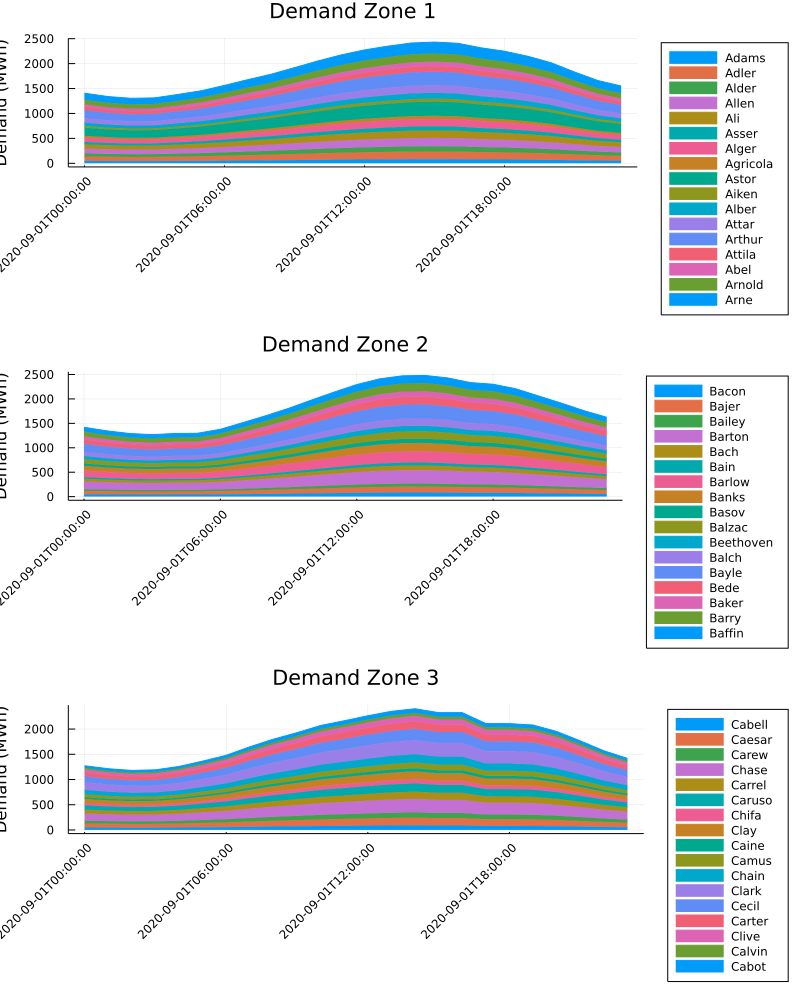

In [11]:
plot(demand_plot[1], demand_plot[2], demand_plot[3], title=["Demand Zone 1" "Demand Zone 2" "Demand Zone 3"], layout=(3,1), size=(800,1000))

In [12]:
net_demand_plot=Dict()
for i in keys(loads)
    net_demand_plot[i]=plot_net_demand_stack(sys_uc, bus_names=unique(vcat(loads[i],renewable[i],renewable_fix[i])), xtickfontsize=8, size=(800, 600),type="Deterministic",
        start_time=DateTime("2020-09-01"))
end

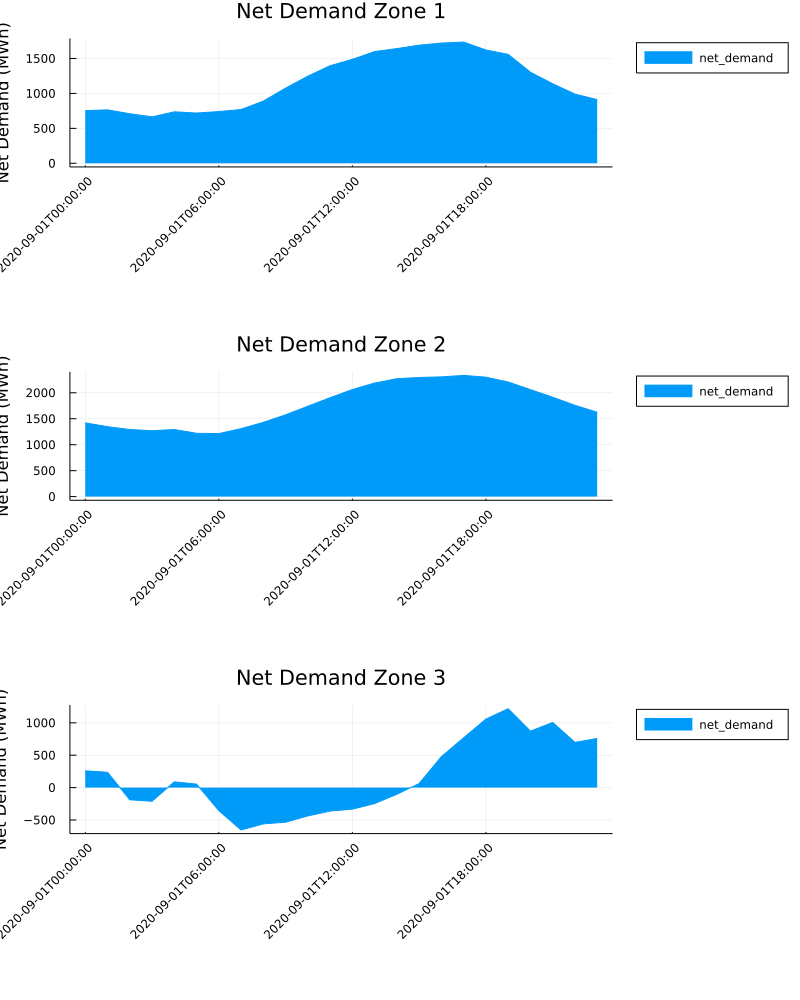

In [13]:
plot(net_demand_plot[1], net_demand_plot[2], net_demand_plot[3], title=["Net Demand Zone 1" "Net Demand Zone 2" "Net Demand Zone 3"], layout=(3,1), size=(800,1000))

In [14]:
renewable_plot=Dict()
for i in keys(renewable)
    renewable[i]=plot_prev_renew_stack(sys_uc, bus_names=unique(vcat(renewable[i],renewable_fix[i])), xtickfontsize=8, size=(800, 600),type="Deterministic",
        start_time=DateTime("2020-09-01"))
end

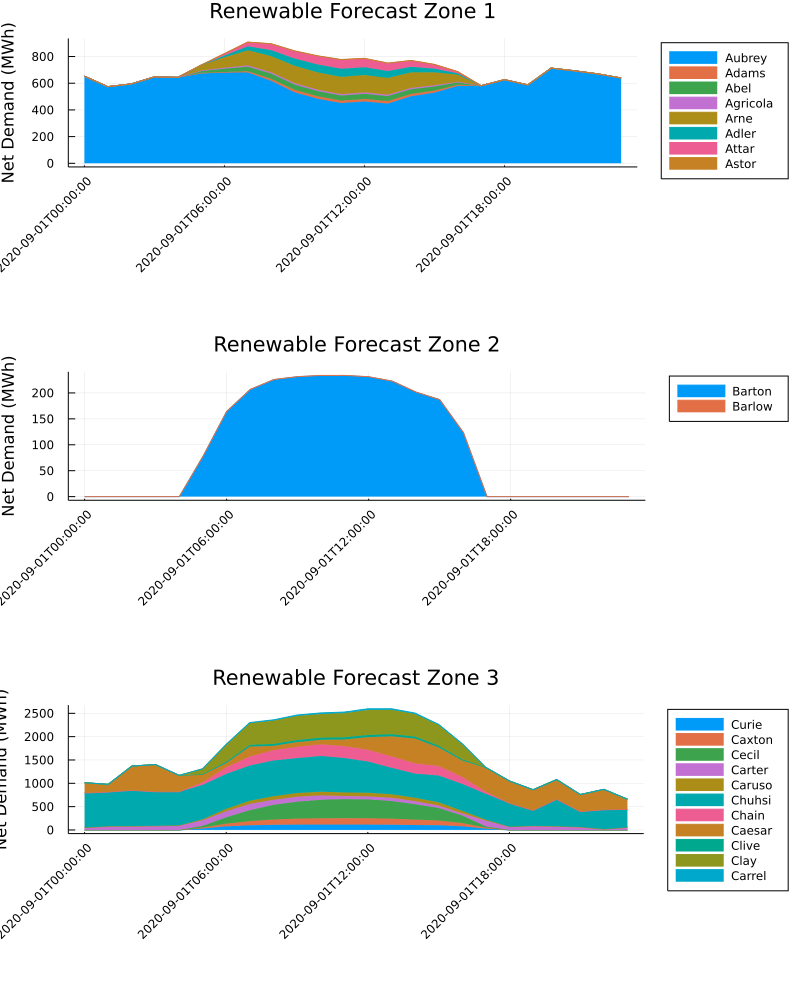

In [15]:
plot(renewable[1], renewable[2], renewable[3], title=["Renewable Forecast Zone 1" "Renewable Forecast Zone 2" "Renewable Forecast Zone 3"], layout=(3,1), size=(800,1000))

## Generation

In [14]:
gen=Dict()
area=["1","2","3"]
for a in area
    gen[a]=Dict()
    g=[get_active_power(i) for i in get_components(ThermalStandard, sys_DA) if 
                (get_name(get_area(get_bus(i))) == a &&
                  get_name(get_area(get_bus(i))) == a)]
    gen[a]["vetor"]=g
    gen[a]["min"]=minimum(g)
    gen[a]["max"]=maximum(g)
    gen[a]["sum"]=sum(g)
    gen[a]["abs_mean"]=sum(abs.(gen[a]["vetor"]))/length(g)
    
end

In [15]:
gen

Dict{Any, Any} with 3 entries:
  "1" => Dict{Any, Any}("sum"=>18.45, "max"=>4.0, "min"=>0.0, "vetor"=>[0.0, 0.…
  "2" => Dict{Any, Any}("sum"=>17.5297, "max"=>3.55, "min"=>0.0, "vetor"=>[0.0,…
  "3" => Dict{Any, Any}("sum"=>23.58, "max"=>3.55, "min"=>0.0, "vetor"=>[0.55, …

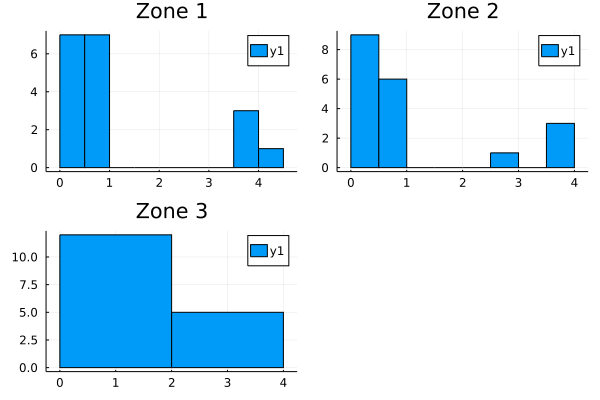

In [16]:
plot(histogram(gen["1"]["vetor"]), histogram(gen["2"]["vetor"]), histogram(gen["3"]["vetor"]), title = 
    ["Zone 1" "Zone 2" "Zone 3"])

## Lines

In [17]:
lines = collect(get_components(Branch, sys_DA));

Collecting min, max, and std_mean capacity of lines for each zone

In [18]:
rate=Dict()
x=Dict()

area=["1","2","3"]
mix_area=[["1" "2"],["2" "3"],["1" "3"]]

for a in area
    rate[a]=Dict()
    r=[get_rate(i) for i in get_components(Branch, sys_DA) if 
                (get_name(get_area(get_from(get_arc(i)))) == a &&
                  get_name(get_area(get_to(get_arc(i)))) == a)]
    rate[a]["vetor"]=r
    rate[a]["min"]=minimum(r)
    rate[a]["max"]=maximum(r)
    rate[a]["abs_mean"]=sum(abs.(rate[a]["vetor"]))/length(r)
    
    x[a]=Dict()
    xl=[get_x(i) for i in get_components(Branch, sys_DA) if 
                (get_name(get_area(get_from(get_arc(i)))) == a &&
                  get_name(get_area(get_to(get_arc(i)))) == a)]
    x[a]["vetor"]=xl
    x[a]["min"]=minimum(xl)
    x[a]["max"]=maximum(xl)
    x[a]["abs_mean"]=sum(abs.(x[a]["vetor"]))/length(xl)
end

for a in mix_area
    rate[a]=Dict()
    r=[get_rate(i) for i in get_components(Branch, sys_DA) if 
                ((get_name(get_area(get_from(get_arc(i)))) == a[1] &&
                  get_name(get_area(get_to(get_arc(i)))) == a[2])|| 
                    (get_name(get_area(get_from(get_arc(i)))) == a[2] &&
                  get_name(get_area(get_to(get_arc(i)))) == a[1]))]
    rate[a]["vetor"]=r
    rate[a]["min"]=minimum(r)
    rate[a]["max"]=maximum(r)
    rate[a]["abs_mean"]=sum(abs.(rate[a]["vetor"]))/length(r)
    
    x[a]=Dict()
    xl=[get_x(i) for i in get_components(Branch, sys_DA) if 
                 ((get_name(get_area(get_from(get_arc(i)))) == a[1] &&
                  get_name(get_area(get_to(get_arc(i)))) == a[2])|| 
                    (get_name(get_area(get_from(get_arc(i)))) == a[2] &&
                  get_name(get_area(get_to(get_arc(i)))) == a[1]))]
    x[a]["vetor"]=xl
    x[a]["min"]=minimum(xl)
    x[a]["max"]=maximum(xl)
    x[a]["abs_mean"]=sum(abs.(x[a]["vetor"]))/length(xl)
end


Looking at the flow capacity between zones, the capacity of zone 3 is considerably smaller than that of the other zones

In [19]:
rate

Dict{Any, Any} with 6 entries:
  "1"       => Dict{Any, Any}("max"=>5.0, "min"=>1.75, "vetor"=>[4.0, 4.0, 4.0,…
  ["1" "2"] => Dict{Any, Any}("max"=>5.0, "min"=>1.75, "vetor"=>[1.75, 5.0, 5.0…
  ["1" "3"] => Dict{Any, Any}("max"=>5.0, "min"=>5.0, "vetor"=>[5.0], "abs_mean…
  "2"       => Dict{Any, Any}("max"=>5.0, "min"=>1.75, "vetor"=>[4.0, 4.0, 4.0,…
  ["2" "3"] => Dict{Any, Any}("max"=>5.0, "min"=>5.0, "vetor"=>[5.0], "abs_mean…
  "3"       => Dict{Any, Any}("max"=>7.22, "min"=>1.75, "vetor"=>[4.0, 4.0, 4.0…

In [20]:
x

Dict{Any, Any} with 6 entries:
  "1"       => Dict{Any, Any}("max"=>0.211, "min"=>0.014, "vetor"=>[0.084, 0.08…
  ["1" "2"] => Dict{Any, Any}("max"=>0.161, "min"=>0.074, "vetor"=>[0.161, 0.07…
  ["1" "3"] => Dict{Any, Any}("max"=>0.097, "min"=>0.097, "vetor"=>[0.097], "ab…
  "2"       => Dict{Any, Any}("max"=>0.211, "min"=>0.014, "vetor"=>[0.084, 0.08…
  ["2" "3"] => Dict{Any, Any}("max"=>0.104, "min"=>0.104, "vetor"=>[0.104], "ab…
  "3"       => Dict{Any, Any}("max"=>0.211, "min"=>0.009, "vetor"=>[0.084, 0.08…

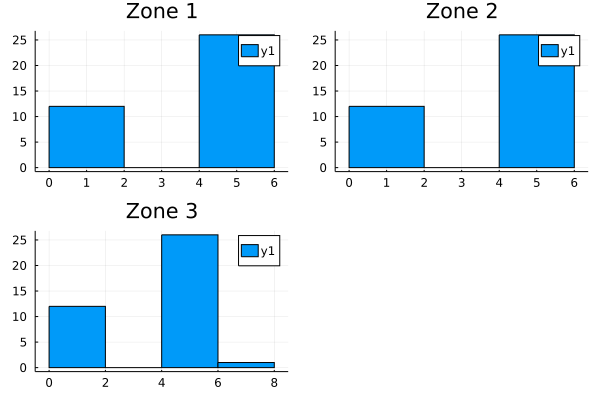

In [21]:
plot(histogram(rate["1"]["vetor"]), histogram(rate["2"]["vetor"]), histogram(rate["3"]["vetor"]), title = 
    ["Zone 1" "Zone 2" "Zone 3"])

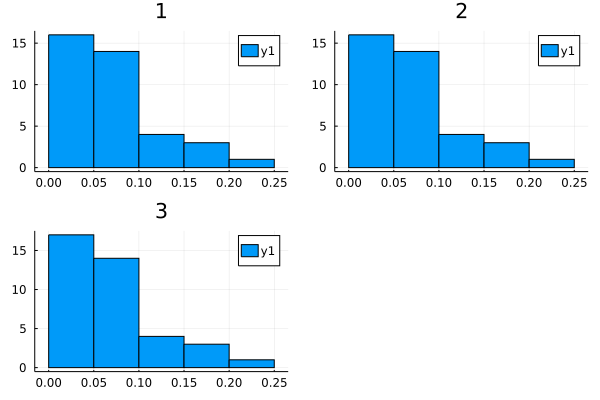

In [22]:
plot(histogram(x["1"]["vetor"]), histogram(x["2"]["vetor"]), histogram(x["3"]["vetor"]), title = [1 2 3])

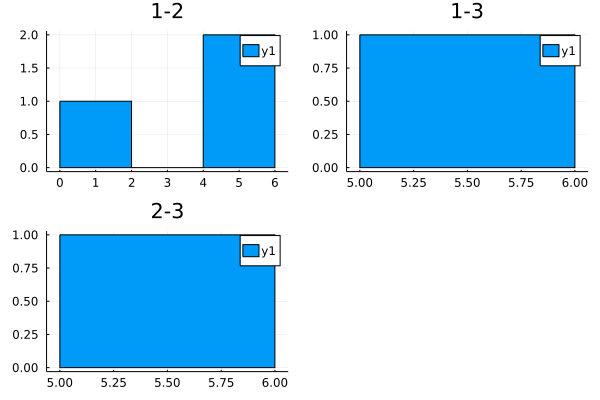

In [23]:
plot(histogram(rate[["1" "2"]]["vetor"]), histogram(rate[["1" "3"]]["vetor"]), histogram(rate[["2" "3"]]["vetor"]), title = ["1-2" "1-3" "2-3"])

### Flow Capacity

In [24]:
#sum(flow capacity of lines connected to bus[i])/bus[i] demand

flow_plot=Dict()
for i in keys(loads)
    flow_plot[i]=plot_flow_capacity_stack(sys_uc, bus_names=loads[i], xtickfontsize=8, size=(800, 600),type="Deterministic",
        start_time=DateTime("2020-09-01"))
end

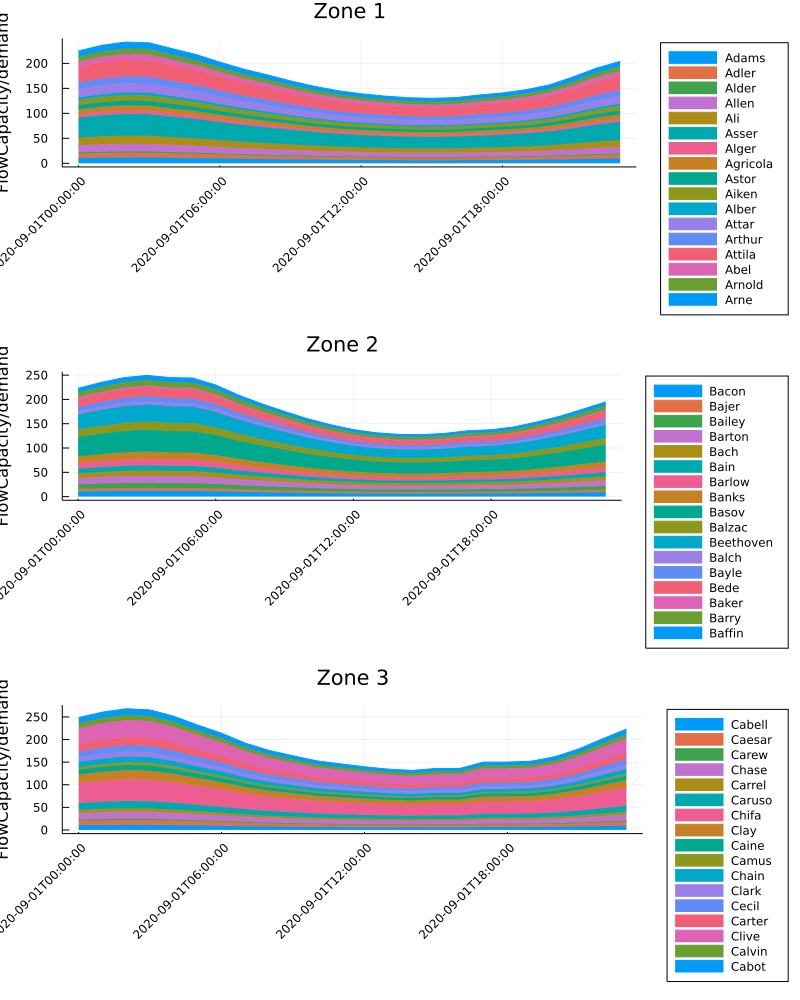

In [25]:
plot(flow_plot[1], flow_plot[2], flow_plot[3], title=["Zone 1" "Zone 2" "Zone 3"], layout=(3,1), size=(800,1000))
